### Implementation for paper 1 inverted pendulum example (Controlled Lagrange)

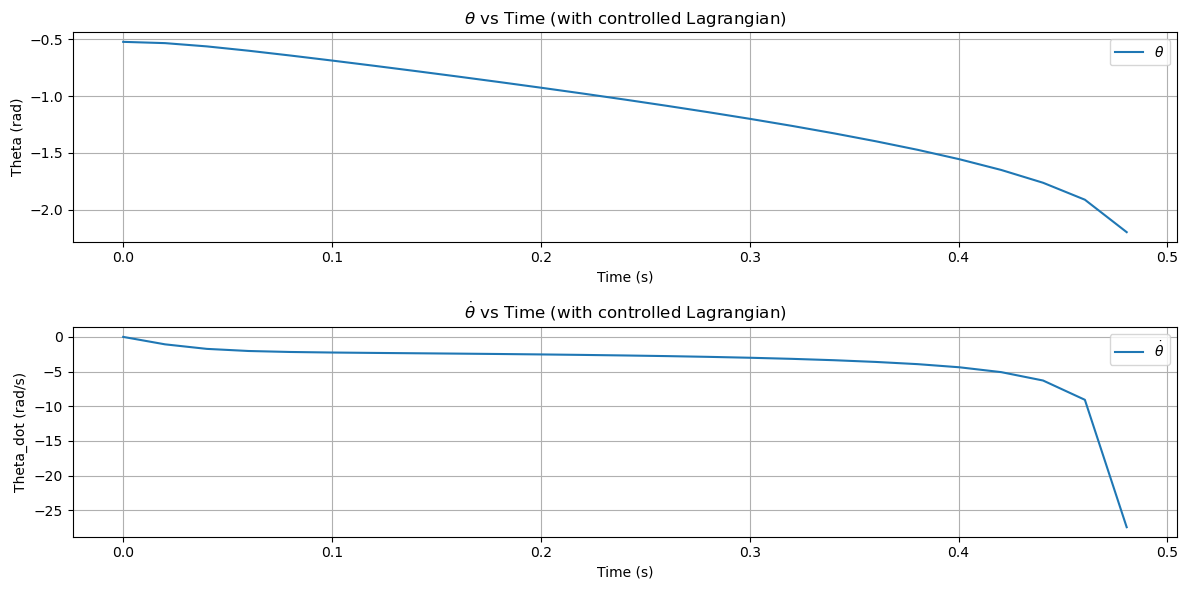

In [19]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
# Now that we have the control law and system dynamics, we will implement the simulation in Python.

# System parameters
m = 1.0  # pendulum mass (kg)
M = 2.0  # cart mass (kg)
l = 1.0  # pendulum length (m)
g = 9.81  # acceleration due to gravity (m/s^2)
alpha = m * l**2  # inertia (kg*m^2)
beta = m * l  # product of mass, gravity, and pendulum length (N*m)
gamma = M + m  # total mass (kg)
D = -m * g * l  # torque due to gravity (N*m)

# Control parameters
kappa = 2  # control gain 

# Control law
def control_law(theta, theta_dot):
    # Define k(θ) as kappa*cos(θ)
    k_theta = kappa * np.cos(theta)

    # Compute ζ (zeta)
    zeta_numerator = D * np.sin(theta) + theta_dot**2 * (beta**2 / gamma + beta * kappa) * np.cos(theta) * np.sin(theta)
    zeta_denominator = alpha - (beta**2 / gamma + beta * kappa) * np.cos(theta)**2
    zeta = zeta_numerator / zeta_denominator

    # Control input u
    u = gamma * kappa * (np.sin(theta) * theta_dot**2 + np.cos(theta) * zeta)

    # Secondary paper
    # num = kappa*beta*(alpha*theta_dot**2 + D * np.cos(theta))
    # den = alpha - (beta**2/gamma)*(1 + kappa) * np.cos(theta)**2
    # u = num/den
    return u

#Equations of motion
def eom(t, y):
    theta, theta_dot = y
    sin = np.sin(theta)
    cos = np.cos(theta)
    k = kappa*beta/(gamma*cos)
    dk = -kappa*sin
    u = control_law(theta, theta_dot)
    num = -(beta**2/gamma*cos*sin - beta*cos*dk) *theta_dot**2 - D*sin
    den = alpha - (beta**2/gamma)*cos**2 - beta*k*cos
    # num = -beta**2*cos*sin*theta_dot**2 - D*sin - beta*cos*u
    # den = gamma*alpha - (beta*cos)**2    
    theta_ddot = (num)/den  # This is already including u.

    return [theta_dot, theta_ddot]





# Initial conditions: small deviation from the unstable equilibrium point
theta0 = -np.pi/6 # initial angle (radians)
theta_dot0 = 0.0  # initial angular velocity (rad/s)

# Time span for the simulation
t_span = [0,20]  # simulate for 20 seconds
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # time points where the solution is sought

# Solve the equations of motion
sol = solve_ivp(eom, t_span, [theta0, theta_dot0], t_eval=t_eval, method='RK45')

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(sol.t, sol.y[0], label=r'$\theta$')
plt.title(r'$\theta$ vs Time (with controlled Lagrangian)')
plt.xlabel('Time (s)')
plt.ylabel('Theta (rad)')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sol.t, sol.y[1], label=r'$\dot{\theta}$')
plt.title(r'$\dot{\theta}$ vs Time (with controlled Lagrangian)')
plt.xlabel('Time (s)')
plt.ylabel('Theta_dot (rad/s)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
(alpha*gamma - beta**2)/beta*gamma

6.0

### Example -- inverted pendulum on a rotor arm

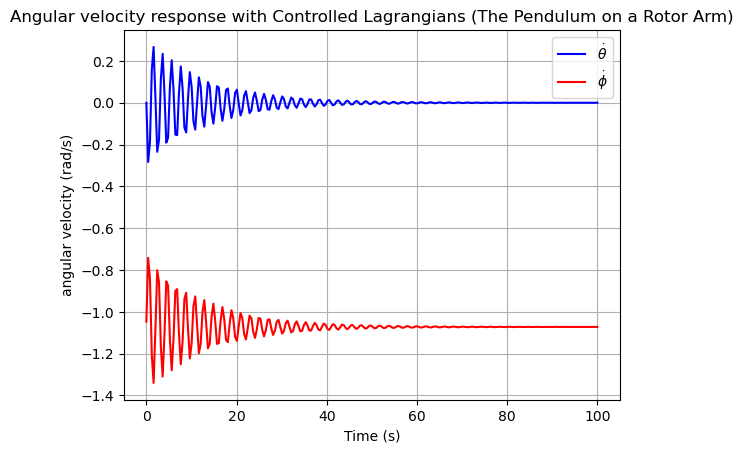

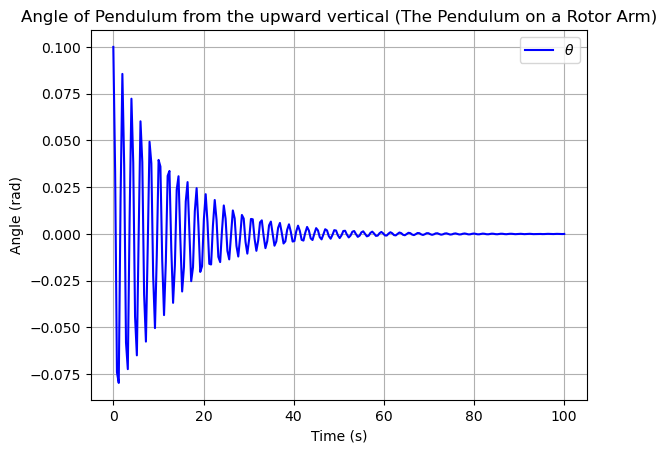

In [39]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# parameters
m = 1.0  # pendulum mass
M = 5.0  # whirling mass
l = 1.0  # pendulum length
g = 9.81 
R = 2.0  # radius of arm 


alpha = m * l**2
beta = m * l
gamma = M + m
D = -m * g * l
# control gain kappa > M/m
kappa = 10

def control_law(theta, dot_theta, phi_dot, kappa, R, alpha, beta, gamma, D):
    numerator = kappa * beta * R * np.sin(theta) * (dot_theta**2 - 2 * alpha* (l / R) * phi_dot * dot_theta * np.cos(theta) - alpha *(np.cos(theta)**2)* phi_dot**2 + D * np.cos(theta))
    denominator = alpha - (beta**2 / gamma) * (1 + kappa) * np.cos(theta)**2 + alpha*(1 + kappa) * (alpha / (gamma * R**2)) * np.sin(theta)**2
    return numerator / denominator


def motion_eqs(y, t, kappa, R, l, g, alpha, beta, gamma, D):
    theta, dot_theta, phi_dot, phi_ddot = y
    sin = np.sin(theta)
    cos = np.cos(theta)
    u = control_law(theta, dot_theta, phi_dot, kappa, R, alpha, beta, gamma, D)
    # From eqn (5.3), we can update the phi_ddot with control law
    phi_ddot_num = beta * R* dot_theta**2 * sin - 2* alpha * phi_dot * dot_theta * cos + phi_dot**2*beta*R*sin*cos + (g*beta*R/l)*sin*cos + u
    phi_ddot_den = gamma*R**2 + alpha*sin**2 + (beta * (R**2)*(cos**2))
    phi_ddot = phi_ddot_num/phi_ddot_den
    ddot_theta = -(R/l)*phi_ddot*cos + phi_dot**2 * sin * cos + g*sin/l

    return [dot_theta, ddot_theta, phi_ddot, phi_dot]

# phi is the angle of mass M from a fixed vertical plane
# phi_ddot was determined by the control law


# Simulation by the updated dynamic eqn
# initial conditions
theta_0 = 0.1      
dot_theta_0 = 0.0  
phi_0 = -np.pi/3 
phi_dot_0 = -np.pi/3

# 时间间隔
t = np.linspace(0, 100, 250)

solution = odeint(motion_eqs, [theta_0, dot_theta_0, phi_dot_0, phi_0], t, args=(kappa, R, l, g, alpha, beta, gamma, D))

plt.figure()
# plt.plot(t, solution[:,0],'b',label=r'$\theta$')
plt.plot(t, solution[:,1],'b',label=r'$\dot{\theta}$')
plt.plot(t, solution[:,2],'r',label=r'$\dot{\phi}$') 
plt.xlabel('Time (s)')
plt.ylabel('angular velocity (rad/s)')
plt.legend()
plt.title('Angular velocity response with Controlled Lagrangians (The Pendulum on a Rotor Arm)')
plt.grid(True)
plt.show()

plt.figure()
# plt.plot(t, solution[:,0],'b',label=r'$\theta$')
plt.plot(t, solution[:,0],'b',label=r'$\theta$')
# plt.plot(t, solution[:,3],'r',label=r'$\phi$') 
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()
plt.title('Angle of Pendulum from the upward vertical (The Pendulum on a Rotor Arm)')
plt.grid(True)
plt.show()

### Rigid Spacecraft with a Symmetric Rotor Example

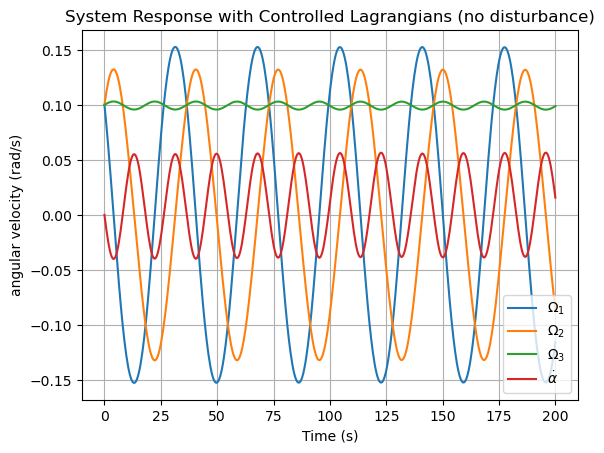

In [13]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


lambda1, lambda2, lambda3, J3 = 1.0, 2.0, 3.0, 1.0 # Interia of each axis.

k =  1.5 # control gain, k > 1 - J3/lambda2

# control law
def control_law(Omega1, Omega2, lambda1, lambda2, J3):
    return k * (lambda1 - lambda2) * Omega1 * Omega2

# Some disturbance
def random_disturbance(t):
    return np.random.normal(0, 0.1)  

def sinusoidal_disturbance(t):
    return 0.1 * np.sin(2 * np.pi * 0.1 * t)

def step_disturbance(t):
    return 1.0 if t > 10 else 0.0  # t=25s 

# Define the dynamic and introduce the contol law
def eom(t,y):
    Omega1, Omega2, Omega3, alpha_dot = y  
    u = control_law(Omega1, Omega2, lambda1, lambda2, J3)
    
    dOmega1_dt = (lambda2 * Omega2 * Omega3 - (lambda3 + J3) * Omega2 * Omega3) / lambda1
    dOmega2_dt = (-lambda1 * Omega1 * Omega3 + (lambda3 + J3) * Omega1 * Omega3) / lambda2
    dOmega3_dt = ((lambda1 - lambda2) * Omega1 * Omega2 - u ) / (lambda3 + J3)
    # dOmega3_dt = ((lambda1 - lambda2) * Omega1 * Omega2 - u + random_disturbance(t)) / (lambda3 + J3) # white noise
    # dOmega3_dt = ((lambda1 - lambda2) * Omega1 * Omega2 - u + sinusoidal_disturbance(t) ) / (lambda3 + J3) # period disturbance
    # dOmega3_dt = ((lambda1 - lambda2) * Omega1 * Omega2 - u + step_disturbance(t)) / (lambda3 + J3) # step dis
    dalpha_dot_dt = (u - J3 * dOmega3_dt) / J3

    # dalpha_dt = alpha_dot # The angular velocity of rotor relative to the spacecraft
    
    return [dOmega1_dt, dOmega2_dt, dOmega3_dt, dalpha_dot_dt]

initial_conditions = [0.1,0.1,0.1, 0] # Start with a small value

t_span = [0, 200] # time interval

# Solve the eqn
solution = solve_ivp(eom, t_span, initial_conditions, t_eval=np.linspace(t_span[0], t_span[1], 500))

plt.figure()
plt.plot(solution.t, solution.y[0], label=r'$\Omega_1$')
plt.plot(solution.t, solution.y[1], label=r'$\Omega_2$')
plt.plot(solution.t, solution.y[2], label=r'$\Omega_3$')
plt.plot(solution.t, solution.y[3], label=r'$\dot{\alpha}$') 
plt.xlabel('Time (s)')
plt.ylabel('angular velocity (rad/s)')
plt.legend()
plt.title('System Response with Controlled Lagrangians (no disturbance)')
plt.grid(True)
plt.show()


#### different ics: [1000,0.1,0.1,0]

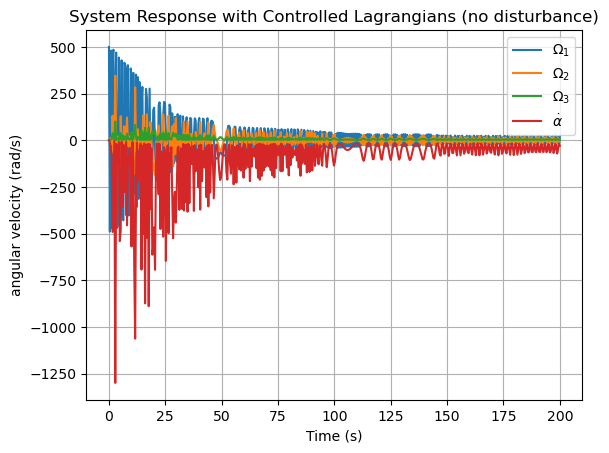

In [24]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


lambda1, lambda2, lambda3, J3 = 1.0, 2.0, 3.0, 1.0 # Interia of each axis.

k =  1.5 # control gain, k > 1 - J3/lambda2

# control law
def control_law(Omega1, Omega2, lambda1, lambda2, J3):
    return k * (lambda1 - lambda2) * Omega1 * Omega2

# Some disturbance
def random_disturbance(t):
    return np.random.normal(0, 0.1)  

def sinusoidal_disturbance(t):
    return 0.1 * np.sin(2 * np.pi * 0.1 * t)

def step_disturbance(t):
    return 1.0 if t > 10 else 0.0  # t=25s 

# Define the dynamic and introduce the contol law
def eom(t,y):
    Omega1, Omega2, Omega3, alpha_dot = y  
    u = control_law(Omega1, Omega2, lambda1, lambda2, J3)
    
    dOmega1_dt = (lambda2 * Omega2 * Omega3 - (lambda3 + J3) * Omega2 * Omega3) / lambda1
    dOmega2_dt = (-lambda1 * Omega1 * Omega3 + (lambda3 + J3) * Omega1 * Omega3) / lambda2
    dOmega3_dt = ((lambda1 - lambda2) * Omega1 * Omega2 - u ) / (lambda3 + J3)
    # dOmega3_dt = ((lambda1 - lambda2) * Omega1 * Omega2 - u + random_disturbance(t)) / (lambda3 + J3) # white noise
    # dOmega3_dt = ((lambda1 - lambda2) * Omega1 * Omega2 - u + sinusoidal_disturbance(t) ) / (lambda3 + J3) # period disturbance
    # dOmega3_dt = ((lambda1 - lambda2) * Omega1 * Omega2 - u + step_disturbance(t)) / (lambda3 + J3) # step dis
    dalpha_dot_dt = (u - J3 * dOmega3_dt) / J3

    # dalpha_dt = alpha_dot # The angular velocity of rotor relative to the spacecraft
    
    return [dOmega1_dt, dOmega2_dt, dOmega3_dt, dalpha_dot_dt]

initial_conditions = [500,0.1,0.1, 0] # Start with a small value

t_span = [0, 200] # time interval

# Solve the eqn
solution = solve_ivp(eom, t_span, initial_conditions, t_eval=np.linspace(t_span[0], t_span[1], 500))

plt.figure()
plt.plot(solution.t, solution.y[0], label=r'$\Omega_1$')
plt.plot(solution.t, solution.y[1], label=r'$\Omega_2$')
plt.plot(solution.t, solution.y[2], label=r'$\Omega_3$')
plt.plot(solution.t, solution.y[3], label=r'$\dot{\alpha}$') 
plt.xlabel('Time (s)')
plt.ylabel('angular velocity (rad/s)')
plt.legend()
plt.title('System Response with Controlled Lagrangians (no disturbance)')
plt.grid(True)
plt.show()
